In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# Once data has been created, the code below in this cell need not be ran every time

# train_dir = "../data/data_main/"
# output_dir = '../output/'

# def is_image_file(filename):
#     return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

# for img in tqdm(os.listdir(train_dir)):
#     if is_image_file(img):
#         img_array = cv2.imread(train_dir + img)
#         img_array = cv2.resize(img_array, (128,128))
#         lr_img_array = cv2.resize(img_array,(32,32))
#         cv2.imwrite(output_dir+ "hr_images/" + img, img_array)
#         cv2.imwrite(output_dir+ "lr_images/"+ img, lr_img_array)

100%|██████████| 25002/25002 [01:12<00:00, 343.57it/s]


In [3]:
os.listdir('../output/lr_images')[0:5]

['im17190.jpg', 'im15167.jpg', 'im15408.jpg', 'im13509.jpg', 'im12804.jpg']

In [6]:
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [7]:
def ResidualBlock(inp):
    
    conv1 = Conv2D(64, (3,3), padding = "same")(inp)
    bn1 = BatchNormalization(momentum = 0.5)(conv1)
    prelu = PReLU(shared_axes = [1,2])(bn1)
    
    conv2 = Conv2D(64, (3,3), padding = "same")(prelu)
    bn2 = BatchNormalization(momentum = 0.5)(conv2)
    elemSum =  add([inp,bn2])
    
    return elemSum

def UpsampleBLock(inp):
    
    conv= Conv2D(256, (3,3), padding="same")(inp)
    pixelShuff = UpSampling2D( size = 2 )(conv)
    prelu = PReLU(shared_axes=[1,2])(pixelShuff)
    
    return prelu


In [8]:

### Generator Block

def Generator(gen_inp, num_res_block):
    conv1 = Conv2D(64, (9,9), padding="same")(gen_inp)
    prelu = PReLU(shared_axes=[1,2])(conv1)

    layers = prelu

    for i in range(num_res_block):
        layers =  ResidualBlock(layers)

    conv2 = Conv2D(64, (3,3), padding="same")(layers)
    bn = BatchNormalization(momentum=0.5)(conv2)
    elemSum = add([bn,prelu])

    upSample1 = UpsampleBLock(elemSum)
    upSample2 = UpsampleBLock(upSample1)

    out = Conv2D(3, (9,9), padding="same")(upSample2)

    return Model(inputs=gen_inp, outputs=out)

In [9]:

### Helper Blocks

def DiscriminatorBlock(inp, filters, strides=1, bn=True):
    
    layer = Conv2D(filters, (3,3), strides = strides, padding="same")(inp)

    if bn:
        layer = BatchNormalization( momentum=0.8 )(layer)
    
    leakyrelu = LeakyReLU( alpha=0.2 )(layer)
    
    return leakyrelu


In [10]:
def Discriminator(disc_inp):

    filter_ker = 64
    
    d1 = DiscriminatorBlock(disc_inp, filter_ker , bn=False)
    d2 = DiscriminatorBlock(d1, filter_ker , strides=2)
    d3 = DiscriminatorBlock(d2,filter_ker*2)
    d4 = DiscriminatorBlock(d3, filter_ker*2, strides=2)
    d5 = DiscriminatorBlock(d4, filter_ker*4)
    d6 = DiscriminatorBlock(d5, filter_ker*4, strides=2)
    d7 = DiscriminatorBlock(d6, filter_ker*8)
    d8 = DiscriminatorBlock(d7, filter_ker*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(filter_ker*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_inp, validity)

### VGG Loss

In [11]:
### Import VGG-19
from keras.applications.vgg19 import VGG19

### Pretained VGG-19 for feature extraction
def Vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

### Combined Model (Generator + Discriminator)

In [12]:
def CombinedModel(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

### Image Loading

In [13]:
### Loading 5k images for training

n=5000
lr_list = os.listdir("../output/lr_images")[:n]
hr_list = os.listdir("../output/hr_images")[:n]

lr_images = []
hr_images = []
for lr_img,hr_img in zip(lr_list, hr_list):
    img_lr = cv2.imread("../output/lr_images/" + lr_img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_hr = cv2.imread("../output/hr_images/" + hr_img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

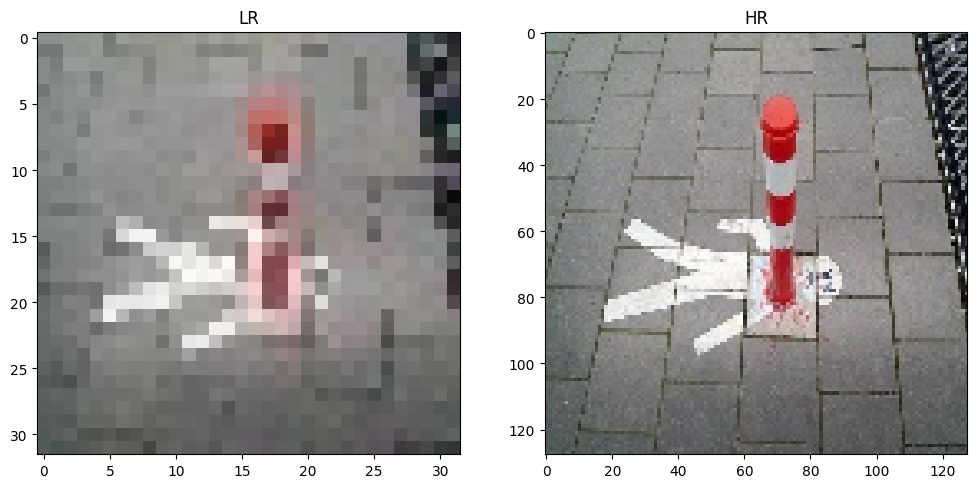

In [14]:
### Checking images

import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.title('LR')
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.title('HR')
plt.show()

### Train-Test Splitting

In [16]:

### Train-Test Split
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)


### Low & High Res shapes
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_inp = Input(shape=lr_shape)
hr_inp = Input(shape=hr_shape)

### GAN

In [17]:
### Genaraotr
generator = Generator(lr_inp, num_res_block = 16)
generator.summary()

### Discriminator
discriminator = Discriminator(hr_inp)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

### VGG
vgg = Vgg((128,128,3))
vgg.summary()
vgg.trainable = False

gan_model = CombinedModel(generator, discriminator, vgg, lr_inp, hr_inp)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_3[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [18]:
### GAN Model
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

### Batching & Training

In [22]:

### Creating images batches
batch_size = 5  
train_lr_batches = []
train_hr_batches = []
for img in tqdm(range(int(hr_train.shape[0] / batch_size))):
    start_idx = img * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

100%|██████████| 670/670 [00:00<00:00, 969363.12it/s]


In [23]:

### Training Loop
EPOCHS = 50

for e in (range(EPOCHS)):
    
    fake_label = np.zeros((batch_size, 1)) # Assigning a label of 0 to all generated images
    real_label = np.ones((batch_size,1)) # Assigning a label of 1 to all real images
    
    g_losses = []
    d_losses = []
    

    for batch in tqdm(range(len(train_hr_batches))):
        
        #Fetching a batch of LR and HR images for training
        lr_imgs = train_lr_batches[batch] 
        hr_imgs = train_hr_batches[batch]
       
        fake_imgs = generator.predict_on_batch(lr_imgs)
        
        #Training of the discriminator on fake and real HR images
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Training on the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Averageing the discriminator loss, for reporting purposes
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extracting VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Training of the generator via GAN. 
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #The average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Reporting of the progress 
    print("Epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    print('#' * 20)

    #Saving the generator after every 10 epochs
    if (e+1) % 10 == 0:
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 87ms/step


  0%|          | 0/50 [05:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
### Load Model

from keras.models import load_model
from numpy.random import randint

# Load previously trained model
generator = load_model('gen_e_40.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

In [ ]:
# plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('SR Image')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Original image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
